
Starter code for Project 2
BIOEN/EE 460/560, CSE 490N
Adapted by TA Matthew J. Bryan for Autumn 2023, from reference code
 written by Student Iman Tanumihardja and TA Courtnie Paschall,
 Autumn 2022.

NOTES:
 * You will need numpy, scipy, and matplotlib installed for the following code
   to work.
 * You are not required to use this starter code, but it will bootstrap your efforts.
 * Since the are many package managers and Python environments available, and
   there are many great walkthroughs online for their use, we will not provide much
   instruction here for managing the dependencies.
 * You must refrain from using dependencies not listed here so the grader doesn't
   need to work to match your environment.

In [65]:
import numpy as np

# For loadmat, which imports data from Matlab files and stores them in memory as
#  scipy tensors.
import scipy.io as sio

# For graphing
import matplotlib.pyplot as plt

# For filtering
from scipy import signal
from scipy.signal import butter, sosfiltfilt, find_peaks

In [66]:
def create_filter_500_to_5k(sample_frequency):
    """
    Returns a discrete time filter coefficients in sos format
    :param sample_frequency: sampling frequency of data
    :return: sos, G
    """

    order = 1  # order, for bandpass filter the effective order is doubled
    lower_cutoff_frequency = 500  # cutoff frequency 1
    upper_cutoff_frequency = 5000  # cutoff frequency 2

    # Design the Butterworth filter
    sos_filter_array = butter(
        order,
        [lower_cutoff_frequency, upper_cutoff_frequency],
        btype="bandpass",
        fs=sample_frequency,
        output="sos",
    )
    print("SOS FILTER ARRAY: ", sos_filter_array)
    return sos_filter_array

In [67]:
# Update data_path to point to your downloaded data
data_path = "ECoGData.mat"
data = sio.loadmat(data_path)

# Create some references to the data so the user doesn't need to copy/paste this indexing elsewhere.
# This first one appears as data.Signal in the Matlab structure. e.g. ECOG_DATA[0] is
#  data.Signal{1, 1}
ECOG_DATA = data["data"]["Signal"][0][0][0]
STIM_TIMES = data["data"]["StimTimes"][0][0][0]
SAMPLE_FREQUENCY = data["data"]["SamplingFreq"][0][0][0][0]

print("Signal: " + str(ECOG_DATA.shape))  # Three stim conditions
print("Stim Times: " + str(STIM_TIMES.shape))  # in seconds!
print("Final stim time: ", STIM_TIMES[0][-1][0])
print("Sample Freq: ", SAMPLE_FREQUENCY)  # 24414 Hz
print("approximate index of final stime: ", SAMPLE_FREQUENCY * (STIM_TIMES[0][-1][0]))
print("data set size: ", len(ECOG_DATA[0]))
print("Seconds in Data set #1: ", len(ECOG_DATA[0]) / SAMPLE_FREQUENCY)

Signal: (3,)
Stim Times: (3,)
Final stim time:  247.45099258422852
Sample Freq:  24414.0625
approximate index of final stime:  6041283.9986383915
data set size:  6325534
Seconds in Data set #1:  259.09387264


In [68]:
sos_filter = create_filter_500_to_5k(SAMPLE_FREQUENCY)

filtered_data_condition_1 = sosfiltfilt(sos_filter, ECOG_DATA[0].flatten())
filtered_data_condition_2 = sosfiltfilt(sos_filter, ECOG_DATA[1].flatten())
filtered_data_condition_3 = sosfiltfilt(sos_filter, ECOG_DATA[2].flatten())

sigma_condition_1 = np.median(np.abs(filtered_data_condition_1) / 0.6745)
sigma_condition_2 = np.median(np.abs(filtered_data_condition_2) / 0.6745)
sigma_condition_3 = np.median(np.abs(filtered_data_condition_3) / 0.6745)

threshold_condition_1 = 3 * sigma_condition_1
threshold_condition_2 = 3 * sigma_condition_2
threshold_condition_3 = 3 * sigma_condition_3

SOS FILTER ARRAY:  [[ 0.39534053  0.         -0.39534053  1.         -1.09785652  0.20931893]]


In [69]:
def create_raster_plot(trials, condition_number):

    plt.figure()
    for trial in trials:  # for each trial
        plt.plot(
        trial["spike_times"],
        np.ones(len(trial["spike_times"])) * trial["trial_number"],
        "k|",
    )

    plt.xticks(ticks=[0, 0.5, 1, 1.5, 2], labels=[-0.5, 0, 0.5, 1, 1.5])

    plt.xlabel("Time (s)")
    plt.ylabel("Trial #")
    plt.title("Condition " + str(condition_number))
    plt.show()

def trial_runner(filtered_data, stimulation_start_times, threshold):

    trials = [
        {
            "trial_number": None,
            "time_window": [None, None], # in seconds
            "ecog_data_index_window": [None, None],
            "spike_indices": [],
            "spike_times": [],
        }
        for _ in range(50)
    ]

    for i, start_time in enumerate(stimulation_start_times):
        # Assign Trial Number
        trials[i]["trial_number"] = i + 1

        # Assign Trial Time Window
        trials[i]["time_window"] = [start_time[0] - 0.5, start_time[0] + 1.5]

        # Assign Trial Ecog index Window
        start_ecog_index = int(trials[i]["time_window"][0] * SAMPLE_FREQUENCY)
        end_ecog_index = int(trials[i]["time_window"][1] * SAMPLE_FREQUENCY)
        trials[i]["ecog_data_index_window"] = [start_ecog_index, end_ecog_index]

        # Find peaks in the window
        peaks, _ = find_peaks(
            filtered_data[start_ecog_index:end_ecog_index], height=threshold
        )
        trials[i]["spike_indices"] = peaks

        # Find spike times in seconds relative to0.5 seconds before stimulation starts
        spike_times = []
        for spike_index in trials[i]["spike_indices"]:
            spike_times.append(spike_index / SAMPLE_FREQUENCY)

        trials[i]["spike_times"] = spike_times

    return trials

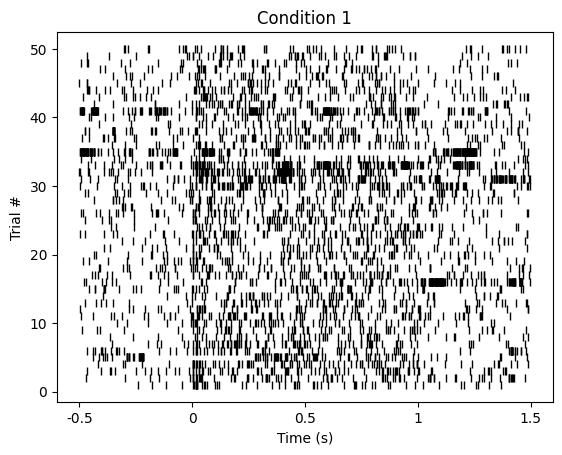

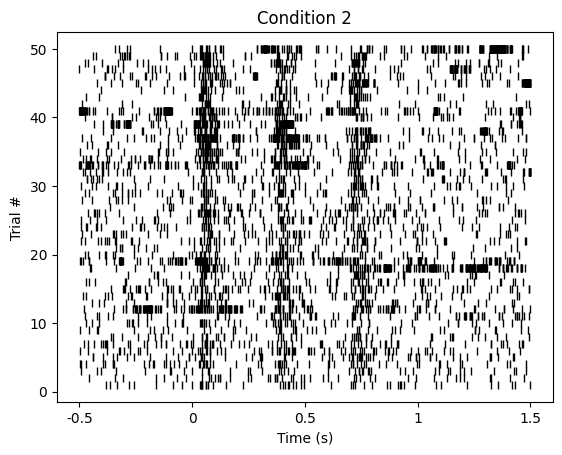

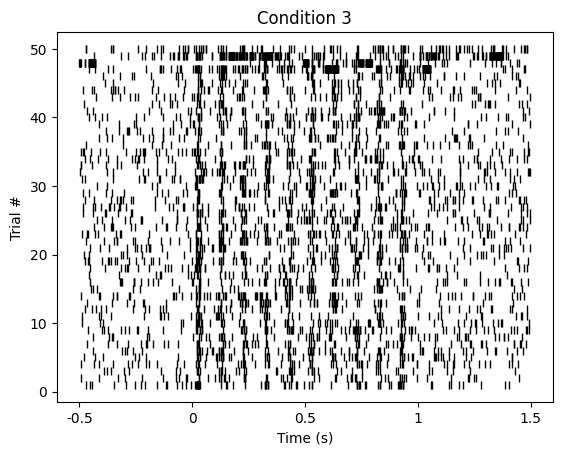

In [70]:
trials_condition_1 = trial_runner(
    filtered_data_condition_1, STIM_TIMES[0], threshold_condition_1
)
trials_condition_2 = trial_runner(
    filtered_data_condition_2, STIM_TIMES[1], threshold_condition_2
)
trials_condition_3 = trial_runner(
    filtered_data_condition_3, STIM_TIMES[2], threshold_condition_3
)

create_raster_plot(trials_condition_1, 1)
create_raster_plot(trials_condition_2, 2)
create_raster_plot(trials_condition_3, 3)

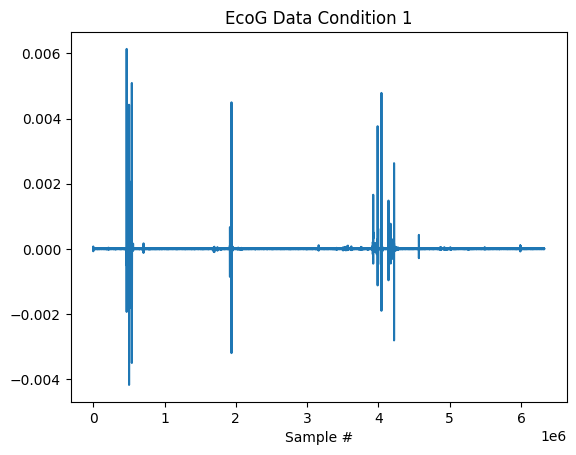

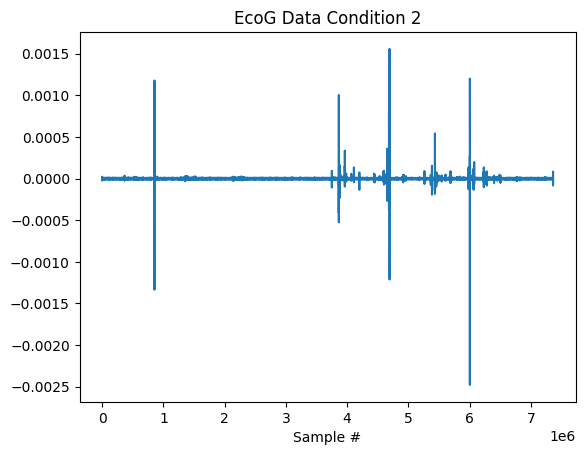

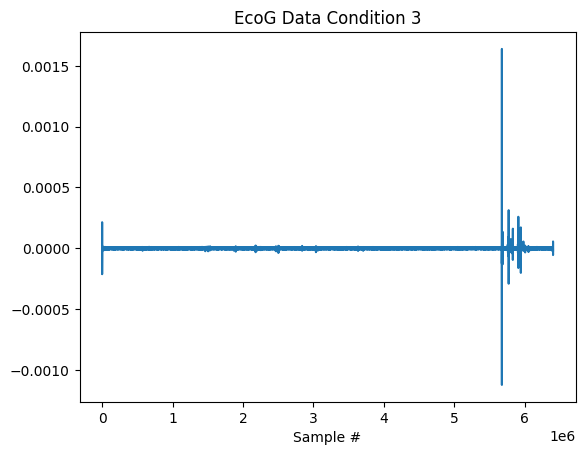

In [71]:
plt.figure()
plt.plot(filtered_data_condition_1, label="ECOG 1")
plt.title("EcoG Data Condition 1")
plt.xlabel("Sample #")

plt.figure()
plt.plot(filtered_data_condition_2, label="ECOG 2")
plt.title("EcoG Data Condition 2")
plt.xlabel("Sample #")

plt.figure()
plt.plot(filtered_data_condition_3, label="ECOG 3")
plt.title("EcoG Data Condition 3")
plt.xlabel("Sample #")

plt.show()